In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';') 

Dataset-a разглежда червено вино и химичния му състав. Целта е да се определи качеството (0-10) на виното от състава му. Състава включва:
* fixed acidity
* volatile acidity
* citric acid
* chlorides
* residual sugar
* free sulfur dioxide
* total sulfur dioxide
* density
* pH
* sulphates
* alcohol

Няма null елементи. Няма и никакви стрингове.

In [2]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Нека да видим дистрибуцията на качеството на виното

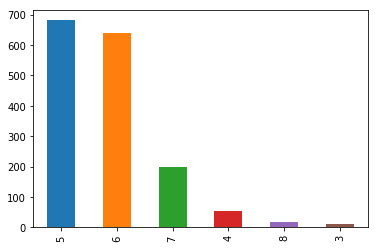

In [3]:
data.quality.value_counts().plot(kind='bar')

Dataset-а е малък и качеството на виното е предимно 5 или 6, плюс това липсват 0, 1, 2, 9, 10, но това не е проблем. Нека си разделим на трейн и тест.

In [4]:
y = data.quality
x = data.drop('quality', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)

X_train = X_train.drop(['density'], axis=1)
X_test = X_test.drop(['density'], axis=1)

След много опити стигнах до извода че няма голяма корелация между quality и density, затова ги премахнах тъй като не подобряваха резултата, даже го влоши. Най голяма корелация между качество и някой фийчър имаше със alcohol и volatile acidity. После си помислих дали може да се направи визуално представяне на корелации и намерих нещо, което не знам колко помага но получих красива картинка :)

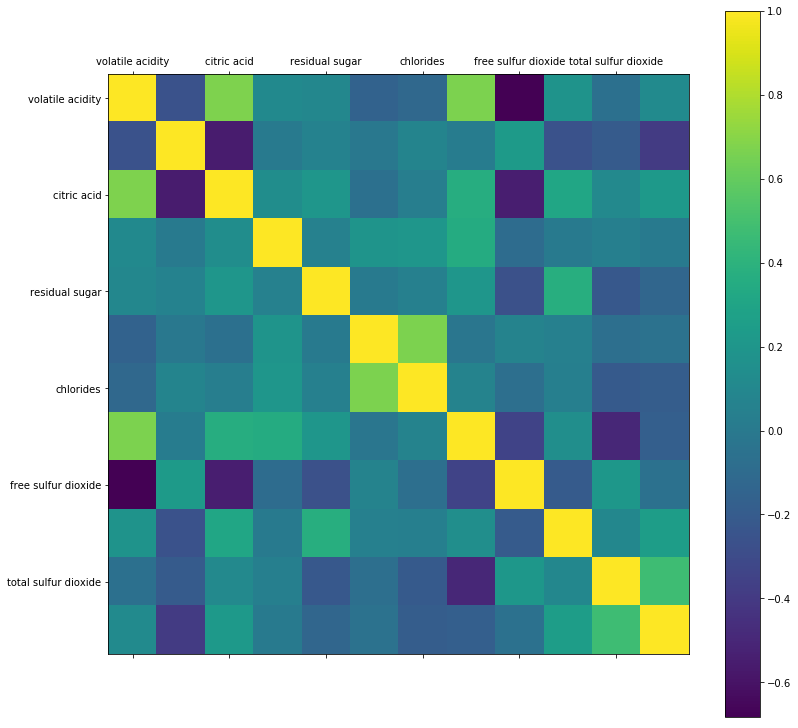

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111)
cax = ax.matshow(data.corr())
fig.colorbar(cax)

ax.set_xticklabels(['']+data.columns)
ax.set_yticklabels(['']+data.columns)

plt.show()


Ето и как изглеждат данните

In [6]:
X_train.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol
812,10.8,0.45,0.33,2.5,0.099,20.0,38.0,3.24,0.71,10.8
1249,7.1,0.60,0.01,2.3,0.079,24.0,37.0,3.40,0.61,10.9
1421,7.5,0.40,0.18,1.6,0.079,24.0,58.0,3.34,0.58,9.4
157,7.1,0.43,0.42,5.5,0.071,28.0,128.0,3.42,0.71,10.5
377,9.4,0.27,0.53,2.4,0.074,6.0,18.0,3.20,1.13,12.0
444,5.3,0.57,0.01,1.7,0.054,5.0,27.0,3.57,0.84,12.5
404,7.7,0.69,0.05,2.7,0.075,15.0,27.0,3.26,0.61,9.1
1075,9.1,0.25,0.34,2.0,0.071,45.0,67.0,3.44,0.86,10.2
185,8.9,0.31,0.57,2.0,0.111,26.0,85.0,3.26,0.53,9.7
1524,6.0,0.42,0.19,2.0,0.075,22.0,47.0,3.39,0.78,10.0


Достатъчно сме разглеждали сета, нека да пробваме няколко модели

In [7]:
from sklearn.linear_model import LinearRegression, LogisticRegression

model = LinearRegression()

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.38491125192844866

Лош резултат. Да пробваме с логистична

In [8]:
model = LogisticRegression()

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.58437499999999998

Малко по-добър резултат. Пробвах и с RidgeClassifier и дава същия. Да видим теглата на логистичната рег.

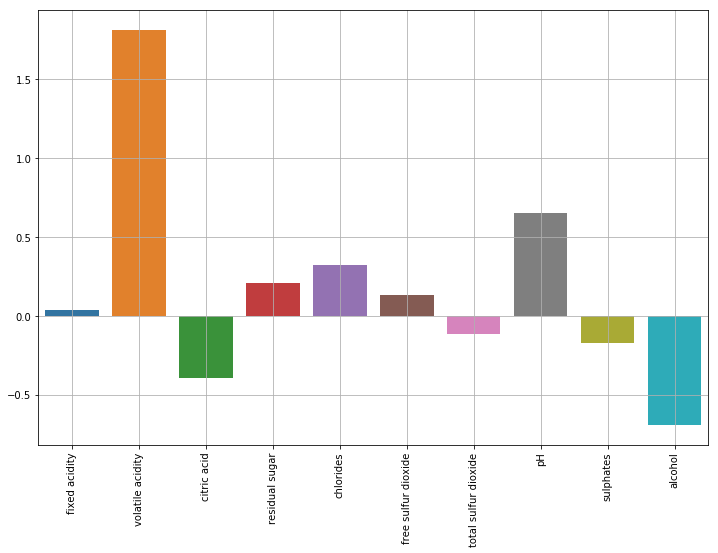

In [9]:
plt.figure(figsize=(12,8))
barplot = sns.barplot(x=X_train.columns, y=model.coef_[0], orient='vertical')
plt.setp(barplot.get_xticklabels(), rotation=90)
plt.grid(True)

Да се пробваме и с KNN.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.59062499999999996

Отново без подобрение. Пробвах с различни стойности на n_neighbors и 1 е оптимално.

Да се надявам че SVM ще даде по добри резултати.

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', SVC(gamma=1, C=0.8))
])


pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.71562499999999996

След grid search имаме 12% подобрение с тези стойности за хиперпараметрите, но резултата пак е мизерен :(

Последно ще пробвам с Random Forest.

In [417]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=120, max_depth=15)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.734375

Минимално подобрение, отново с Grid search.

###### Dataset-a е доста прост, но явно или е малък, или има твърде много класове, или просто е труден за предиктване. Може би виното просто не може толкова лесно да бъде категоризирано по качества само на базис на химическия му състав. Може би оценката е силно субективна, човешка, невлияеща се от състава на виното :Д. Евентуално може да намаля броя на класовете, но за друго не се сещам.